這邊主要利用tf2.0來練習MNIST，原始keras的api皆有保留，做個簡單的小測試。

In [6]:
import tensorflow as tf
import numpy as np

In [27]:
tf.__version__

'2.0.0'

接著下載MNIST資料集

In [7]:
mnist = tf.keras.datasets.mnist

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 2s 0us/step


取得資料之後都一定要先確認相關維度資訊，而不是直接使用

In [9]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [10]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

這邊我們並沒有特別將label的部份轉one hot encoder

In [11]:
y_test[0]

7

因為影像本身為灰階，因此需要外推一個軸出去，讓它變為28x28x1才能符合模型訓練維度，這有兩種作法，`np.reshape`或`np.expand_dims`

In [12]:
x_train = np.expand_dims(x_train, 3)

In [13]:
x_train.shape

(60000, 28, 28, 1)

In [14]:
x_test = x_test.reshape(10000, 28, 28, 1)

In [15]:
x_test.shape

(10000, 28, 28, 1)

接下來要對資料做大小標準化，提高訓練效率

In [16]:
x_train = x_train / 255.
x_test = x_test / 255.

可以先簡單確認，圖像的大小為28x28，而且是灰階圖。

簡單列印幾張照片來確認

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

隨機取得10個索引

In [18]:
index = np.random.randint(0, 60000, size=10)
index

array([53639, 20805, 49306, 27253, 58341, 34478,   138, 15988, 14579,
       33726])

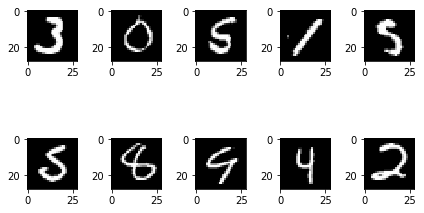

In [19]:
i = 0
for idx in index:
    plt.subplot(str(25)+str(i))    
    plt.imshow(x_train[idx][:, :, 0], cmap='gray')
    i += 1

plt.tight_layout()
plt.show()

指定硬體資源，相關可[參考](https://hackmd.io/@shaoeChen/ryWIV4vkL)

In [20]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

In [28]:
gpus 

[PhysicalDevice(name=u'/physical_device:GPU:0', device_type=u'GPU'),
 PhysicalDevice(name=u'/physical_device:GPU:1', device_type=u'GPU')]

In [21]:
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')

In [22]:
tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)

利用標準的keras Sequential來建置模型

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), padding='valid', activation='tanh'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='tanh'),
    tf.keras.layers.Dense(84, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax'),
])


確認模型

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

編譯模型

因為我們並未將label轉one-hot encoder，因此必需使用`sparse_categorical_crossentropy`做為loss function

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [26]:
model.fit(x_train, 
          y_train, 
          batch_size=64,
          epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 105us/sample - loss: 0.7156 - accuracy: 0.8242
Epoch 2/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2176 - accuracy: 0.9389
Epoch 3/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.1429 - accuracy: 0.9590
Epoch 4/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.1082 - accuracy: 0.9688
Epoch 5/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0892 - accuracy: 0.9738
Epoch 6/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0768 - accuracy: 0.9776
Epoch 7/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0680 - accuracy: 0.9798
Epoch 8/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0614 - accuracy: 0.9817
Epoch 9/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0558 - accuracy: 0.9838
Epoch 10/10
6

即使在tf2.0還是可以持續使用熟悉的keras，感覺甚好。